In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn
import sklearn.tree
import sklearn.ensemble
import sklearn.metrics
import scipy
import scipy.stats

In [2]:
#Setup data file path(s)
cwd = os.getcwd()
parent_directory = os.path.dirname(cwd)
data_directory = parent_directory + '\\data'
data_paths = [
    data_directory + '\\mr_bike_demand.csv',
    data_directory + '\\mr_dock_demand.csv'
]
weather_path = data_directory + '\\weather.csv'

In [3]:
station_bike_demand = pd.read_csv(data_paths[0], index_col='start_date', parse_dates=['start_date']).asfreq('D')


In [4]:
# Split station data into training and test set
data_train = station_bike_demand['2014':'2018']
data_test  = station_bike_demand['2019':'2019']

# Add zeros for 2014 before April to have consistent period windows
df = pd.DataFrame(index=pd.date_range(start='2014-01-01', end='2014-04-01', freq='D'), columns=['trip_count'])
df['trip_count'] = 0
data_train = pd.concat([df, data_train])

# Exclude November data from the test set
#data_test  = data_test[:'2019-10-31']
display(data_train.head())

,trip_count
2014-01-01,0
2014-01-02,0
2014-01-03,0
2014-01-04,0
2014-01-05,0


In [5]:
#Generate Training Data

#Split dates into day/month/year columns
years = np.array(data_train.index.year)
months = np.array(data_train.index.month)
days = np.array(data_train.index.day)

#Form feature vectors
X_train_raw = np.column_stack((years,months,days))
#Make target vector
y_train_raw = np.array(data_train['trip_count'])

#Verify Training X and y
print(X_train_raw.shape)
print(y_train_raw.shape)

#print(X_train[X_train.shape[0]-5 : X_train.shape[0]])             
#print(y_train[y_train.shape[0]-5 : X_train.shape[0]])

(1813, 3)
(1813,)


In [6]:
#Generate Test Data
test_years = np.array(data_test.index.year)
test_months = np.array(data_test.index.month)
test_days = np.array(data_test.index.day)
#Form feature vectors
X_2019_test = np.column_stack((test_years,test_months,test_days))
#Make target vector
y_2019_test = np.array(data_test['trip_count'])


print(X_2019_test.shape)
print(y_2019_test.shape)

(365, 3)
(365,)


In [7]:
#Define Hyperparameters to search over
np.random.seed(1)
n_trials = 25
num_trees = np.random.randint(1,500,size = n_trials)
depths = np.random.randint(1,10,size = n_trials)
print("Number of Trees used: ", num_trees)
print("Maximum tree Depths: ", depths)

#Define variables to hold results
MSQ_by_trial = np.zeros(n_trials)
percent_error_by_trial = np.zeros(n_trials)

Number of Trees used:  [ 38 236 397  73 256 394 204 134 336 449 145 130 461  72 238 391 282 179
 277 255 358 403 469 396 253]
Maximum tree Depths:  [3 5 8 8 2 8 1 7 8 7 2 1 2 9 9 4 9 8 4 7 6 2 4 5 9]


In [8]:
#Use time series variant of K-fold cross validation to generate estimates of Test time performance
#Collect Data to later be used to define the final model.

splitter=sklearn.model_selection.TimeSeriesSplit(n_splits = 4)
j=0
for n_trees,depth in zip(num_trees,depths):
    i=0
    #print("Testing model with hyperparams of num_trees:",n_trees, " and max_depth: ", depth)
    print("Testing model {} of {}".format(j+1,n_trials), "num_trees:", n_trees, " and max_depth: ", depth)
    percentage_errors = np.zeros(4)
    MSQs = np.zeros(4)
    for train_index, test_index in splitter.split(X_train_raw):
        #print("TRAIN:", train_index, "\nTEST:", test_index)
        X_train, X_test = X_train_raw[train_index], X_train_raw[test_index]
        y_train, y_test = y_train_raw[train_index], y_train_raw[test_index]
        i+=1
        #Define and Fit our Model.
        model = sklearn.ensemble.RandomForestRegressor(n_estimators= n_trees,
                                                   max_depth = depth, random_state=0)
        model = model.fit(X_train,y_train)
        
        #Make predictions and generate useful metrics
        y_pred = model.predict(X_test)
        msq = sklearn.metrics.mean_squared_error(y_test,y_pred)
        mae = sklearn.metrics.mean_absolute_error(y_test,y_pred)

        #Save metrics in an array for later analysis
        percentage_errors[i-1] = mae/np.mean(y_test)*100
        
        MSQs[i-1] = msq
        
        #print("For test fold ", i)
        #print("Mean Squared Error: ", msq)
        #print("Mean Absolute Error: ", mae)
        #print("Mean of y_test: ", np.mean(y_test))
        #print("Mean absolute % error: ", (mae/np.mean(y_test)*100),"%")
   
    #print("Average % error across test folds: ", np.mean(percentage_errors))
    #print("Average MSQ across test folds: ", np.mean(MSQs))
    MSQ_by_trial[j] = np.mean(MSQs)
    #percent_error_by_trial[j] = np.mean(percentage_errors)
    percent_error_by_trial[j] = percentage_errors[3]

    j+=1
print('done')

Testing model 1 of 25 num_trees: 38  and max_depth:  3
Testing model 2 of 25 num_trees: 236  and max_depth:  5
Testing model 3 of 25 num_trees: 397  and max_depth:  8
Testing model 4 of 25 num_trees: 73  and max_depth:  8
Testing model 5 of 25 num_trees: 256  and max_depth:  2
Testing model 6 of 25 num_trees: 394  and max_depth:  8
Testing model 7 of 25 num_trees: 204  and max_depth:  1
Testing model 8 of 25 num_trees: 134  and max_depth:  7
Testing model 9 of 25 num_trees: 336  and max_depth:  8
Testing model 10 of 25 num_trees: 449  and max_depth:  7
Testing model 11 of 25 num_trees: 145  and max_depth:  2
Testing model 12 of 25 num_trees: 130  and max_depth:  1
Testing model 13 of 25 num_trees: 461  and max_depth:  2
Testing model 14 of 25 num_trees: 72  and max_depth:  9
Testing model 15 of 25 num_trees: 238  and max_depth:  9
Testing model 16 of 25 num_trees: 391  and max_depth:  4
Testing model 17 of 25 num_trees: 282  and max_depth:  9
Testing model 18 of 25 num_trees: 179  and 

Best Classifier Attributes: 
Number of Estimators:  768 Max Depth:  10
Avg. % error of best classifier:  16.816934065458934
MSQ of best classifer:  926.816157862454


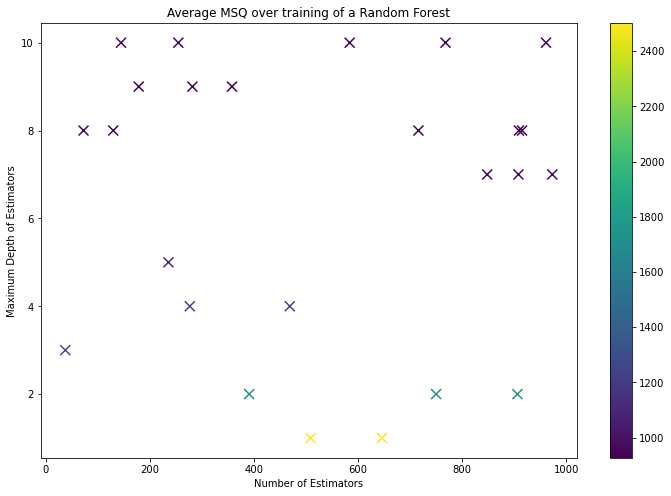

In [20]:
#Code for plotting a summary of hyperparameter effects on MSQ
plt.figure(figsize =(12,8));
plt.scatter(num_trees, depths, marker = 'x', c = MSQ_by_trial, s = 100)
plt.colorbar()
plt.title("Average MSQ over training of a Random Forest")
plt.xlabel("Number of Estimators")
plt.ylabel("Maximum Depth of Estimators");
#print("Min MSQ: ", np.min(MSQ_by_trial))
#print(np.argmin(MSQ_by_trial))
print("Best Classifier Attributes: ")
print("Number of Estimators: ", num_trees[np.argmin(MSQ_by_trial)], "Max Depth: ", depths[np.argmin(MSQ_by_trial)])
print("Avg. % error of best classifier: ", percent_error_by_trial[np.argmin(MSQ_by_trial)] )
print("MSQ of best classifer: ", MSQ_by_trial[np.argmin(MSQ_by_trial)])

Final num estimators used:  358
Final max depth used:  6
Mean Squared Error:  1452.283552232992
Root Mean Squared Error:  38.10883824302431
Mean Absolute Error:  23.423250099819853
Mean of y_test:  119.9972602739726
Mean of y_pred:  119.43464908610221
Mean absolute % error:  19.354081249309047 %


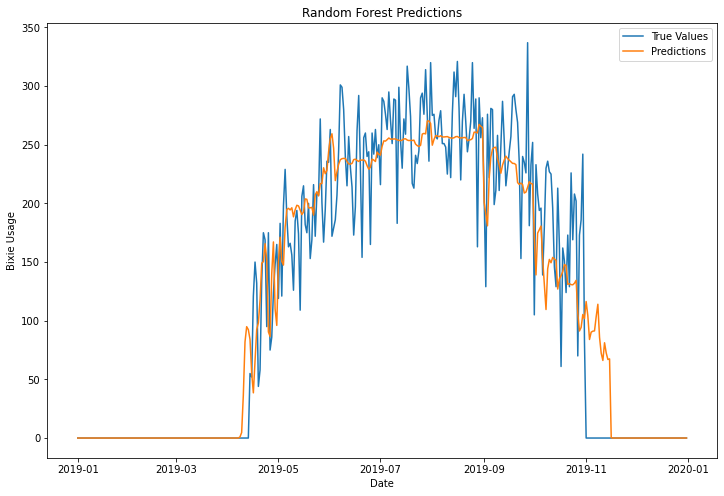

In [10]:
#Final Model Training and Performance
#Define model using best parameters found in random sweep
#Could perform more detailed sweep around target but the MSQ seems quite stable across depth >=3

#Define the final model using the parameters found with the best performance 
final_model = sklearn.ensemble.RandomForestRegressor(
    n_estimators= num_trees[np.argmin(MSQ_by_trial)],
    max_depth = depths[np.argmin(MSQ_by_trial)], random_state=0)

#Train model on all data from 2014:2018
model = model.fit(X_train_raw,y_train_raw)
        
#Make predictions and generate useful metrics
y_final_pred = model.predict(X_2019_test)
msq = sklearn.metrics.mean_squared_error(y_2019_test,y_final_pred)
mae = sklearn.metrics.mean_absolute_error(y_2019_test,y_final_pred)
rmse = sklearn.metrics.mean_squared_error(y_2019_test,y_final_pred, squared = False)


print("Final num estimators used: ", num_trees[np.argmin(MSQ_by_trial)])
print("Final max depth used: ", depths[np.argmin(MSQ_by_trial)])
print("Mean Squared Error: ", msq)
print("Root Mean Squared Error: ", rmse)

print("Mean Absolute Error: ", mae)
print("Mean of y_test: ", np.mean(y_2019_test))
print("Mean of y_pred: ", np.mean(y_final_pred))
print("Mean absolute % error: ", (mae/np.mean(y_test)*100),"%")

plt.figure(figsize = (12,8))
plt.plot(data_test.index, y_2019_test, label = "True Values")
plt.plot(data_test.index, y_final_pred, label = "Predictions")

plt.legend();
plt.xlabel("Date")
plt.ylabel("Bixie Usage")
plt.title("Random Forest Predictions");

In [11]:
#Redo everything but add in Weather!
weather_info = pd.read_csv(weather_path, index_col='date_time', parse_dates=['date_time']).asfreq('D')


In [12]:
# Split station data into training and test set
wxr_train = weather_info['2014':'2018']
wxr_test  = weather_info['2019':'2019']

# Add zeros for 2014 before April to have consistent period windows
#df = pd.DataFrame(index=pd.date_range(start='2014-01-01', end='2014-04-01', freq='D'), columns=['trip_count'])
#df['trip_count'] = 0
#data_train = pd.concat([df, data_train])

# Exclude November data from the test set
#wxr_test  = wxr_test[:'2019-10-31']
#display(wxr_train.head())
#display(wxr_train.tail())
#display(data_train.head())
#display(data_train.tail())
#print(wxr_train.shape)
#print(data_train.shape)

data_train_wxr = data_train.join(wxr_train)
y_train_wxr = y_train_raw
y_test_wxr = y_2019_test
data_test_wxr = data_test.join(wxr_test)

display(data_train_wxr.head())
display(data_test_wxr.head())


,trip_count,max_temp,min_temp,mean_temp,total_precip,max_gust
2014-01-01,0,-15.2,-23.9,-19.6,0.0,31.0
2014-01-02,0,-22.3,-27.4,-24.9,0.0,37.0
2014-01-03,0,-19.0,-23.6,-21.3,1.0,31.0
2014-01-04,0,-6.6,-21.3,-14.0,0.0,31.0
2014-01-05,0,0.2,-10.6,-5.2,8.0,31.0


,trip_count,max_temp,min_temp,mean_temp,total_precip,max_gust
start_date,,,,,,
2019-01-01,0,2.3,-11.7,-4.7,19.7,37.0
2019-01-02,0,-9.1,-14.9,-12.0,0.2,0.2
2019-01-03,0,-3.0,-13.8,-8.4,2.9,32.0
2019-01-04,0,2.9,-3.0,0.0,3.7,48.0
2019-01-05,0,2.4,1.0,1.7,0.0,0.0


In [13]:
#Generate Training Features

#Split dates into day/month/year columns
years = np.array(data_train_wxr.index.year)
months = np.array(data_train_wxr.index.month)
days = np.array(data_train_wxr.index.day)

wxr_train_info = data_train_wxr[["max_temp","min_temp","mean_temp","total_precip","max_gust"]]

#Form feature vectors
X_train_wxr = np.column_stack((years,months,days))

#Verify Training X and y
print(X_train_wxr.shape)
print(wxr_train_info.shape)
X_train_wxr = np.hstack((X_train_wxr,wxr_train_info))
y_train_wxr = np.array(data_train_wxr["trip_count"])
print(X_train_wxr.shape)
print(X_train_wxr[0:5])
print(y_train_wxr.shape)


#print(X_train_wxr[X_train_wxr.shape[0]-5 : X_train_wxr.shape[0]])             
#print(y_train_wxr[y_train_wxr.shape[0]-5 : X_train_wxr.shape[0]])

(1813, 3)
(1813, 5)
(1813, 8)
[[ 2.014e+03  1.000e+00  1.000e+00 -1.520e+01 -2.390e+01 -1.960e+01
   0.000e+00  3.100e+01]
 [ 2.014e+03  1.000e+00  2.000e+00 -2.230e+01 -2.740e+01 -2.490e+01
   0.000e+00  3.700e+01]
 [ 2.014e+03  1.000e+00  3.000e+00 -1.900e+01 -2.360e+01 -2.130e+01
   1.000e+00  3.100e+01]
 [ 2.014e+03  1.000e+00  4.000e+00 -6.600e+00 -2.130e+01 -1.400e+01
   0.000e+00  3.100e+01]
 [ 2.014e+03  1.000e+00  5.000e+00  2.000e-01 -1.060e+01 -5.200e+00
   8.000e+00  3.100e+01]]
(1813,)


In [14]:
#generate test features

#Generate Feature Data
test_years = np.array(wxr_test.index.year)
test_months = np.array(wxr_test.index.month)
test_days = np.array(wxr_test.index.day)
wxr_test_info = data_test_wxr[["max_temp","min_temp","mean_temp","total_precip","max_gust"]]

#Form feature vectors
X_test_wxr = np.column_stack((test_years,test_months,test_days))
X_test_wxr = np.hstack((X_test_wxr,wxr_test_info))

#Make target vector
y_test_wxr = np.array(data_test_wxr['trip_count'])


#display(X_test_wxr[100:110])
#display(y_test_wxr[100:110])


In [15]:
#Define Hyperparameters to search over
np.random.seed(1)
n_trials = 25
num_trees = np.random.randint(1,1000,size = n_trials)
depths = np.random.randint(1,11,size = n_trials)
print("Number of Trees used: ", num_trees)
print("Maximum tree Depths: ", depths)

#Define variables to hold results
MSQ_by_trial = np.zeros(n_trials)
percent_error_by_trial = np.zeros(n_trials)

Number of Trees used:  [ 38 236 909  73 768 906 716 646 848 961 145 130 973 584 750 509 391 282
 179 277 255 358 915 469 908]
Maximum tree Depths:  [ 3  5  8  8 10  2  8  1  7 10 10  8  7 10  2  1  2  9  9  4 10  9  8  4
  7]


In [16]:
%%time
#Use time series variant of K-fold cross validation to generate estimates of Test time performance
#Collect Data to later be used to define the final model.

splitter=sklearn.model_selection.TimeSeriesSplit(n_splits = 4)
j=0
for n_trees,depth in zip(num_trees,depths):
    i=0
    #print("Testing model with hyperparams of num_trees:",n_trees, " and max_depth: ", depth)
    print("Training model {} of {}".format(j+1,n_trials), "num_trees:", n_trees, " and max_depth: ", depth)
    percentage_errors = np.zeros(4)
    MSQs = np.zeros(4)
    for train_index, test_index in splitter.split(X_train_wxr):
        #print("TRAIN:", train_index, "\nTEST:", test_index)
        X_train, X_test = X_train_wxr[train_index], X_train_wxr[test_index]
        y_train, y_test = y_train_wxr[train_index], y_train_wxr[test_index]
        i+=1
        #Define and Fit our Model.
        model = sklearn.ensemble.RandomForestRegressor(n_estimators= n_trees,
                                                   max_depth = depth, random_state=0)
        model = model.fit(X_train,y_train)
        
        #Make predictions and generate useful metrics
        y_pred = model.predict(X_test)
        msq = sklearn.metrics.mean_squared_error(y_test,y_pred)
        mae = sklearn.metrics.mean_absolute_error(y_test,y_pred)

        #Save metrics in an array for later analysis
        percentage_errors[i-1] = mae/np.mean(y_test)*100
        MSQs[i-1] = msq
        
        #print("For test fold ", i)
        #print("Mean Squared Error: ", msq)
        #print("Mean Absolute Error: ", mae)
        #print("Mean of y_test: ", np.mean(y_test))
        #print("Mean absolute % error: ", (mae/np.mean(y_test)*100),"%")
   
    #Quanitfy performance based on average across test folds
    #MSQ_by_trial[j] = np.mean(MSQs)
    #percent_error_by_trial[j] = np.mean(percentage_errors)
    
    #Quantify performance based on test fold with largest training set
    MSQ_by_trial[j] = MSQs[3]
    percent_error_by_trial[j] = percentage_errors[3]
    j+=1
    
print("Done!")

Training model 1 of 25 num_trees: 38  and max_depth:  3
Training model 2 of 25 num_trees: 236  and max_depth:  5
Training model 3 of 25 num_trees: 909  and max_depth:  8
Training model 4 of 25 num_trees: 73  and max_depth:  8
Training model 5 of 25 num_trees: 768  and max_depth:  10
Training model 6 of 25 num_trees: 906  and max_depth:  2
Training model 7 of 25 num_trees: 716  and max_depth:  8
Training model 8 of 25 num_trees: 646  and max_depth:  1
Training model 9 of 25 num_trees: 848  and max_depth:  7
Training model 10 of 25 num_trees: 961  and max_depth:  10
Training model 11 of 25 num_trees: 145  and max_depth:  10
Training model 12 of 25 num_trees: 130  and max_depth:  8
Training model 13 of 25 num_trees: 973  and max_depth:  7
Training model 14 of 25 num_trees: 584  and max_depth:  10
Training model 15 of 25 num_trees: 750  and max_depth:  2
Training model 16 of 25 num_trees: 509  and max_depth:  1
Training model 17 of 25 num_trees: 391  and max_depth:  2
Training model 18 of 

Best Classifier Attributes: 
Number of Estimators:  768 Max Depth:  10
% error of best classifier:  16.816934065458934
MSQ of best classifer:  926.816157862454


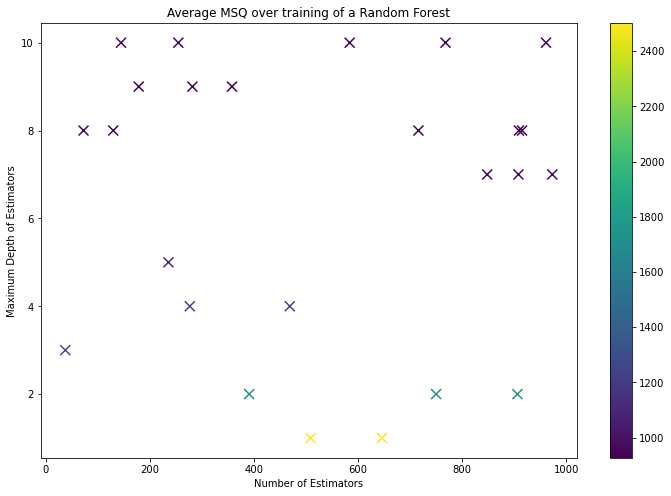

In [21]:
#Code for plotting a summary of hyperparameter effects on MSQ
plt.figure(figsize =(12,8));
plt.scatter(num_trees, depths, marker = 'x', c = MSQ_by_trial, s = 100)
plt.colorbar()
plt.title("Average MSQ over training of a Random Forest")
plt.xlabel("Number of Estimators")
plt.ylabel("Maximum Depth of Estimators");
#print("Min MSQ: ", np.min(MSQ_by_trial))
#print(np.argmin(MSQ_by_trial))
print("Best Classifier Attributes: ")
print("Number of Estimators: ", num_trees[np.argmin(MSQ_by_trial)], "Max Depth: ", depths[np.argmin(MSQ_by_trial)])
print("% error of best classifier: ", percent_error_by_trial[np.argmin(MSQ_by_trial)] )
print("MSQ of best classifer: ", MSQ_by_trial[np.argmin(MSQ_by_trial)])

Final num estimators used:  768
Final max depth used:  10
Mean Squared Error:  1208.797358840099
Root Mean Square Error:  34.767763213069934
Mean Absolute Error:  22.181509820709913
Mean of y_test:  119.9972602739726
Mean of y_pred:  114.84832347463416
Mean absolute % error:  18.328060430250368 %


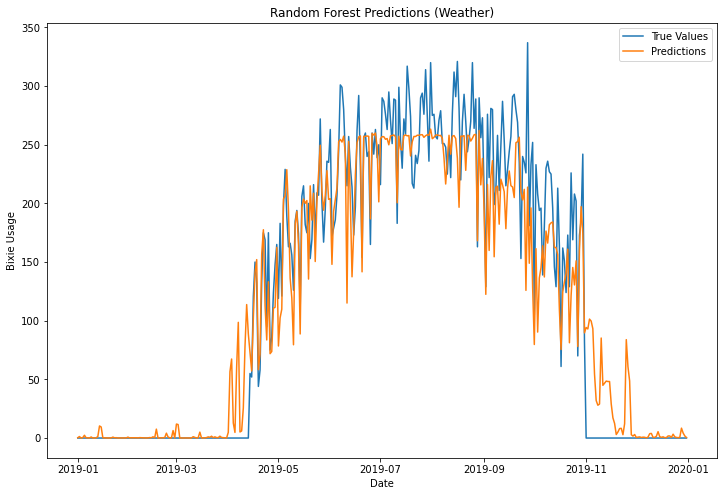

In [18]:
#Define the final model using the parameters found with the best performance 
final_model = sklearn.ensemble.RandomForestRegressor(
    n_estimators= num_trees[np.argmin(MSQ_by_trial)],
    max_depth = depths[np.argmin(MSQ_by_trial)], random_state=0)

#Train model on all data from 2014:2018
model = model.fit(X_train_wxr,y_train_wxr)

        
#Make predictions and generate useful metrics
y_final_pred = model.predict(X_test_wxr)
#y_final_pred[0:100] = 0
msq = sklearn.metrics.mean_squared_error(y_test_wxr,y_final_pred)
rmse = sklearn.metrics.mean_squared_error(y_test_wxr,y_final_pred, squared = False)
mae = sklearn.metrics.mean_absolute_error(y_test_wxr,y_final_pred)

print("Final num estimators used: ", num_trees[np.argmin(MSQ_by_trial)])
print("Final max depth used: ", depths[np.argmin(MSQ_by_trial)])
print("Mean Squared Error: ", msq)
print("Root Mean Square Error: ", rmse)
print("Mean Absolute Error: ", mae)
print("Mean of y_test: ", np.mean(y_test_wxr))
print("Mean of y_pred: ", np.mean(y_final_pred))
print("Mean absolute % error: ", (mae/np.mean(y_test)*100),"%")

plt.figure(figsize = (12,8))

plt.plot(data_test.index, y_test_wxr, label = "True Values")
plt.plot(data_test.index, y_final_pred, label = "Predictions")

plt.legend()
plt.xlabel("Date")
plt.ylabel("Bixie Usage")
plt.title("Random Forest Predictions (Weather)");